In [1]:
import numpy as np
import torch
from torch import nn
import torch.distributions as dist
import matplotlib.pyplot as plt
import scipy.stats as st
import math
import os
import pickle
from sklearn.utils import shuffle
# get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import arviz as az
import pyro
import pyro.distributions as dist_pyro
from pyro.infer import MCMC, HMC, NUTS
import argparse
import json

pyro.set_rng_seed(37)

np.random.seed(120)
torch.manual_seed(120)

In [2]:
n_steps=200000
num_particles=32
n_y=64 
lr=1e-3
realnvp_architecture=[15,100]
job='a'

len_flow, num_neurons = realnvp_architecture[0], realnvp_architecture[1]
print(n_steps, num_particles, n_y, lr, len_flow, num_neurons, job)
print('results_dir')

200000 32 64 0.001 15 100 a
results_dir


In [3]:
# parser=argparse.ArgumentParser()
# parser.add_argument('-n_steps', dest='n_steps', type=int, default=100, help='Maximum number of iterations.')
# parser.add_argument('-num_particles', dest='num_particles', type=int, default=5, help='Number of particles to consider in each iteration.')
# parser.add_argument('-n_y', dest='n_y', type=int, default=32, help='Number of observed data samples to consider in each iteration.')
# parser.add_argument('-lr', dest='lr', type=float, default=1e-3, help='Learning rate.')
# parser.add_argument('-realnvp_architecture', dest='realnvp_architecture', type=json.loads, default="[15, 100]",  help='RealNVP architecture parametersas list: [Length of flow, Number of neurons].')
# parser.add_argument('-job', dest='job', type=str, default='a', help='Model variation currently trying.')
# args = parser.parse_args()

# # Print all the arguments
# for arg in vars(args):
#     print(f'{arg}: {getattr(args, arg)}')

# n_steps = args.n_steps
# num_particles = args.num_particles
# n_y = args.n_y
# lr = args.lr
# len_flow, num_neurons = args.realnvp_architecture[0], args.realnvp_architecture[1]
# job = args.job
# print(n_steps, num_particles, n_y, lr, len_flow, num_neurons, job)

# Specify the directory name
results_dir = os.path.join(os.getcwd(), 'results-'+str(job)) 
# Check if the directory already exists; if not, create it
if not os.path.exists(results_dir):
    os.makedirs(results_dir)


# In[3]:


xi_dim = 4 
y_dim = 2
noise_scale = torch.tensor([0.01, 0.01])
lens = torch.tensor([0.5, 0.5, 1.0]) # lengths of the kinematic links
prior_scale = torch.tensor([0.25, 0.5, 0.5, 0.5]) # prior scale

# Defining prior distribution
prior_xi_dist = dist.Normal(loc=torch.zeros(xi_dim), scale=prior_scale)


# In[4]:


def segment_points(p_, length, angle):
    p = torch.zeros(p_.shape)
    p[:,0] = p_[:,0] + length * torch.cos(angle)
    p[:,1] = p_[:,1] + length * torch.sin(angle)
    return p_, p

def forward_process(xi): # N x d_xi
    """
    Implements the forward process f(xi) and 
    and returns each of the arm’s end points as dictionary.
    """
    values = dict();
    xi = xi.reshape(-1,4)
    A = torch.stack([torch.zeros((xi.shape[0])), xi[:, 0]], axis=1)
    _, B = segment_points(A, lens[0], xi[:,1])
    _, C = segment_points(B, lens[1], xi[:,1] + xi[:,2])
    _, D = segment_points(C, lens[2], xi[:,1] + xi[:,2] + xi[:,3])
    values['A'] = A
    values['B'] = B
    values['C'] = C
    values['D'] = D
    return values;


# In[5]:


class RealNVP(nn.Module):
    def __init__(self, base_dist, split_dim, len_flow, nets, nett, neta, netb, perm):
        super(RealNVP, self).__init__()
        
        self.base_dist = base_dist
        self.split_dim = split_dim
        self.len_flow = len_flow
        self.t = torch.nn.ModuleList([nett() for _ in range(self.len_flow)])
        self.s = torch.nn.ModuleList([nets() for _ in range(self.len_flow)])
        self.a = torch.nn.ModuleList([neta() for _ in range(self.len_flow)])
        self.b = torch.nn.ModuleList([netb() for _ in range(self.len_flow)])
        self.perm = perm

    # forward transformation z, y --> xi, xi = g(z, y), log_det_J here is new/old
    def g(self, z, y):
        log_det_J = z.new_zeros(z.shape[0])
        xi = z
        for i in range(self.len_flow):
            u1, u2 = torch.split(xi, split_size_or_sections= [self.split_dim, z.shape[1]-self.split_dim], dim=-1)
            v1 = ( u1 * torch.exp(self.s[i]( torch.cat((u2, y), dim=1) )) ) + self.t[i]( torch.cat((u2, y), dim=1) )
            v2 = ( u2 * torch.exp(self.a[i]( torch.cat((v1, y), dim=1) )) ) + self.b[i]( torch.cat((v1, y), dim=1) )
            log_det_J +=  self.s[i]( torch.cat((u2, y), dim=1) ).sum(-1) + self.a[i]( torch.cat((v1, y), dim=1) ).sum(-1) 
            xi = torch.cat((v1, v2), dim=-1)
            if i < self.len_flow-1:
                xi = torch.matmul(xi, self.perm[i])   
        return xi, log_det_J
        
    def sample(self, z, y): 
        xi = self.g(z, y)[0]
        return xi


# In[6]:

class AVI(nn.Module):
    def __init__(self, xi_dim=4, y_dim=2, f=forward_process, noise_scale=0.01):
        super().__init__()
        
        self.xi_dim = xi_dim
        self.y_dim = y_dim
        self.f = f
        self.noise_scale = noise_scale
        
        self.input_dim = xi_dim
        self.split_dim = int(xi_dim/2)

        self.nets = lambda: nn.Sequential(nn.Linear(self.input_dim-self.split_dim+self.y_dim, num_neurons), nn.LeakyReLU(), nn.Linear(num_neurons, num_neurons), nn.LeakyReLU(), nn.Linear(num_neurons, self.split_dim), nn.Tanh())
        self.nett = lambda:  nn.Sequential(nn.Linear(self.input_dim-self.split_dim+self.y_dim, num_neurons), nn.LeakyReLU(), nn.Linear(num_neurons, num_neurons), nn.LeakyReLU(), nn.Linear(num_neurons, self.split_dim))

        self.neta = lambda: nn.Sequential(nn.Linear(self.split_dim+self.y_dim, num_neurons), nn.LeakyReLU(), nn.Linear(num_neurons, num_neurons), nn.LeakyReLU(), nn.Linear(num_neurons, self.input_dim-self.split_dim), nn.Tanh())
        self.netb = lambda: nn.Sequential(nn.Linear(self.split_dim+self.y_dim, num_neurons), nn.LeakyReLU(), nn.Linear(num_neurons, num_neurons), nn.LeakyReLU(), nn.Linear(num_neurons, self.input_dim-self.split_dim))

        self.len_flow = len_flow

        self.base_dist = dist.MultivariateNormal(torch.zeros(self.input_dim), torch.eye(self.input_dim))
        
        perm_file_path = os.path.join(results_dir, 'perm.pkl')
        if os.path.exists(perm_file_path):
            with open(perm_file_path, 'rb') as file:
                self.perm = pickle.load(file)
        else:
            self.perm = []
            arr =  torch.eye(self.input_dim)
            for i in range(self.len_flow-1):
                self.perm.append(shuffle(arr)) #random_state=i
            with open(perm_file_path, 'wb') as file:
                pickle.dump(self.perm, file)

        self.model = RealNVP(self.base_dist, self.split_dim, self.len_flow, self.nets, self.nett, self.neta, self.netb, self.perm)
    
    def observed_data(self, n=30):
        xi_data = dist.Normal(loc=torch.zeros(self.xi_dim), scale=prior_scale).sample([n])
        y_data = self.f(xi_data)['D'] + self.noise_scale * torch.randn(*self.f(xi_data)['D'].shape)
        return xi_data, y_data
    
    def log_joint(self, xi, y): # xi is z_k
        
        log_prior = dist.Normal(loc=torch.zeros(self.xi_dim), scale=prior_scale).log_prob(xi).sum(axis=1)
        log_likelihood = dist.Normal(loc=self.f(xi)['D'], scale=self.noise_scale).log_prob(y).sum(axis=1)
        log_joint = log_prior + log_likelihood

        return log_joint
    
    def forward(self, num_particles=2):
        np.random.seed(120)
        torch.manual_seed(120)
        
        _, y = self.observed_data(n=n_y)
        
        loss = 0
        for i in range(y.shape[0]):
            
            y_samples = y[i,:].repeat(num_particles, 1)
            z_samples = torch.autograd.Variable( self.base_dist.sample((num_particles, )) )
            z_k, log_det_J = self.model.g(z_samples, y_samples)
            loss_ = (- self.log_joint(z_k, y[i,:]) + self.base_dist.log_prob(z_samples) - log_det_J).mean()
            #or
            #loss_ = (- self.log_joint(z_k, y[i,:]) - log_det_J).mean()
            loss += loss_
    
        return loss/y.shape[0]
        

In [4]:
steps, gradient_norms, learning_rates = [], [], []

for step in range(n_steps):
    if (step % 10000 == 0) or (step == n_steps - 1):
        m = AVI(xi_dim=xi_dim, y_dim=y_dim, f=forward_process, noise_scale=noise_scale)
        checkpoint_loaded = torch.load(os.path.join(results_dir,'checkpoint_{}.pt'.format(step)))

        step = checkpoint_loaded ['step']
        optimizer_state_dict = checkpoint_loaded['optimizer_state_dict']  
        model_state_dict = checkpoint_loaded['model_state_dict']  
        # print(step)
        # print(optimizer_state_dict)
        # print(model_state_dict )
        m.load_state_dict(model_state_dict)
        
        loss = m(num_particles=num_particles)
        loss.backward()
        
        # Get the model parameters
        parameters = [p for p in m.model.parameters() if p.requires_grad==True]

        # Compute the gradient norm
        gradient_norm = 0.0
        for param in parameters:
            if param.grad is not None:
                gradient_norm += param.grad.norm()

        
        print('step %s:' % step, 'gradient_norm = %.3f,' % gradient_norm,  'lr = %.5f' % optimizer_state_dict['param_groups'][0]['lr'])
        steps.append(step)
        gradient_norms.append(gradient_norm.item())
        learning_rates.append(optimizer_state_dict['param_groups'][0]['lr'])


step 0: gradient_norm = 2012918.125, lr = 0.00100
step 10000: gradient_norm = 1804.737, lr = 0.00100
step 20000: gradient_norm = 1563.761, lr = 0.00100
step 30000: gradient_norm = 1886.712, lr = 0.00100
step 40000: gradient_norm = 1668.728, lr = 0.00100
step 50000: gradient_norm = 2907.569, lr = 0.00100
step 60000: gradient_norm = 1347.585, lr = 0.00100
step 70000: gradient_norm = 1335.664, lr = 0.00100
step 80000: gradient_norm = 2287.469, lr = 0.00100
step 90000: gradient_norm = 3953.543, lr = 0.00100
step 100000: gradient_norm = 1451.791, lr = 0.00100
step 110000: gradient_norm = 936.846, lr = 0.00100
step 120000: gradient_norm = 1227.711, lr = 0.00100
step 130000: gradient_norm = 772.581, lr = 0.00100
step 140000: gradient_norm = 947.432, lr = 0.00100
step 150000: gradient_norm = 892.338, lr = 0.00100
step 160000: gradient_norm = 787.948, lr = 0.00100
step 170000: gradient_norm = 1898.743, lr = 0.00100
step 180000: gradient_norm = 1473.167, lr = 0.00100
step 190000: gradient_norm =

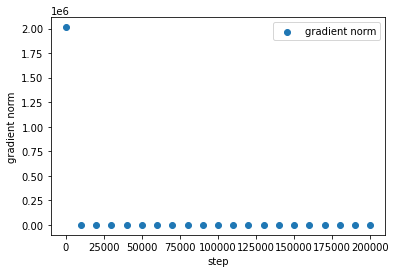

In [5]:
plt.figure()
plt.scatter(steps, gradient_norms, label = 'gradient norm')
plt.xlabel('step')
plt.ylabel('gradient norm')
plt.legend()